Maximum sequence length: 175


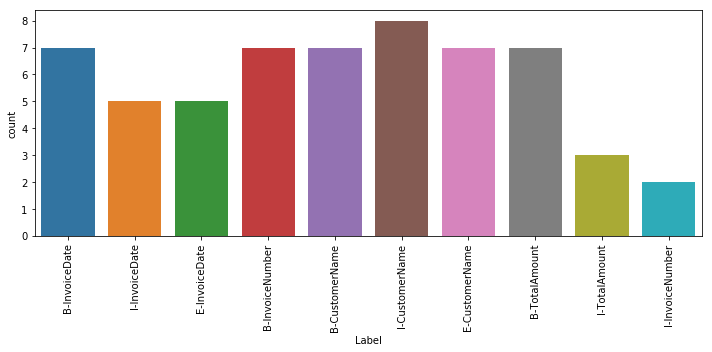

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 175)               0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 175, 200)          141800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 175, 200)          0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 175, 400)          641600    
_________________________________________________________________
time_distributed_17 (TimeDis (None, 175, 11)           4411      
_________________________________________________________________
crf_17 (CRF)                 (None, 175, 11)           275       
Total params: 788,086
Trainable params: 788,086
Non-trainable params: 0
_________________________________________________________________
Trai

In [19]:
#!pip install git+https://www.github.com/keras-team/keras-contrib.git

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
import matplotlib.pyplot as plt
import seaborn as sns
from keras_contrib.layers import CRF
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score, classification_report
import logging
import warnings
warnings.filterwarnings('ignore')
logger = logging.getLogger(__name__)



"Reading input files"
invoice_df = pd.read_csv("../input/nerdataset/LabelledDataNER.csv", encoding = "ISO-8859-1", error_bad_lines=False)
invoice_df.head(n=2)
logger.info("***** Reading dataset completed *****")
logger.info(" Size of dataset = %d", len(invoice_df))
invoice_df.drop('Filename',axis=1, inplace = True)
invoice_data =invoice_df.copy()


"Function to get sentences separately"
def sentence_getter(sent):
    agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Label"].values.tolist())]
    grouped = invoice_data.groupby("SentenceID").apply(agg_func)
    sentences = [s for s in grouped]
    return sentences

sentences=sentence_getter(invoice_data)

maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)


#Words distribution across Labels
import seaborn as sns
plt.figure(figsize=(10, 5))
ax = sns.countplot('Label', data=invoice_data.loc[invoice_data['Label'] != 'Other'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()


words = list(set(invoice_data["Word"].values)) #unique words
n_words = len(words) #no of unique words
labels = list(set(invoice_data["Label"].values))  #unique labels
n_labels = len(labels) #no of tags



"Converting words to numbers and numbers to words"
from future.utils import iteritems
word2id = {w: i for i, w in enumerate(words)}
tag2id = {t: i for i, t in enumerate(labels)}
id2tag = {v: k for k, v in iteritems(tag2id)}

#Model Building
from keras.preprocessing.sequence import pad_sequences
X = [[word2id[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=175, sequences=X, padding="post",value=0)

y = [[tag2id[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=175, sequences=y, padding="post", value=1)
y = [to_categorical(i, num_classes=n_labels) for i in y]

input = Input(shape=(175,))
word_embedding_size = 200
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=175)(input)
model=Dropout(0.2)(model)
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                          dropout = 0.1
                           ))(model)
model = TimeDistributed(Dense(n_labels, activation="relu"))(model)  

crf = CRF(n_labels)  # CRF layer
out = crf(model)  # output
model = Model(input, out)
model.summary()


#adam = k.optimizers.Adam(lr=0.0005)
model.compile(optimizer='adam', loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
# Train!
logger.info("***** Running training *****")
logger.info("  Num examples = %d", len(X_train))
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=6, validation_split=0.2, verbose=1) #training the model

pred = model.predict(np.array([X_test[0]]))
pred = np.argmax(pred, axis=-1)
gt = np.argmax(y_test[0], axis=-1)

print("{:14}: ({:5}): {}".format("Word", "True", "Pred"))
for idx, (w,pred) in enumerate(zip(X_test[0],pred[0])):
    #
    print("{:14}: ({:15}): {}".format(words[w],id2tag[gt[idx]],labels[pred]))


pred = model.predict(np.array(X_test))  

# ## Standard Classification Report
print(classification_report(np.argmax(y_test, 2).ravel(), np.argmax(pred, axis=2).ravel(),labels=list(id2tag.keys()), target_names=list(id2tag.values())))
F1_score=f1_score(y_test[0],pred[0],average='weighted')
print("F1 score:",F1_score)

##!pip install transformers


#from transformers import BertTokenizer, BertConfig


#tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False) 


